In [6]:
import os
import numpy as np
import nibabel as nib
from nibabel.affines import apply_affine
import matplotlib.pyplot as plt
import scipy.interpolate as inter
from sklearn.ensemble import RandomForestClassifier
import pickle

In [7]:
#tableau qui contient les coordonnées des blocks
coordinate = []
#tab espérance position organe
esperance = [[0 for i in range(6)] for i in range(23)]

In [8]:
#create block of BlockSize from ONE slice !!!---> blocks
def createBlocks(layer, zCoord, blockSize):
        blocks = []

        for i in range(int(512/blockSize)):
                for j in range(int(512/blockSize)):
                        blocks.append(layer[i*blockSize : blockSize*(i+1), j*blockSize : blockSize*(j+1)])
                        #print(str(len(blocks)) + " : x=" + str(blockSize*(2*i+1)/2) + " y=" + str(blockSize*(2*j+1)/2) + " z=" + str(zCoord))
                        coordinate.append([(blockSize*(2*i+1)/2), (blockSize*(2*j+1)/2), zCoord])
        return blocks

#convert scanner relative value [-1023, 2976] to [0, 255]
def convertValues(blocks):
        for k in range(len(blocks)):
                for j in range(len(blocks[0])):
                        blocks[k][j] = int(0.063766 * (blocks[k][j] + 1023))


#create tab to test :
def probaBlocks(blocks):
        blocksTest = []

        for k in range(len(blocks)):
                testTab = []
                for i in range(len(blocks[0])):
                        for j in range(len(blocks[0])):
                                testTab.append(blocks[k][i][j])
                blocksTest.append(testTab)

        return rf.predict_proba(blocksTest)

def maxProbaBlocks(blocks):
        blocksTest = []

        for k in range(len(blocks)):
                testTab = []
                for i in range(len(blocks[0])):
                        for j in range(len(blocks[0])):
                                testTab.append(blocks[k][i][j])
                blocksTest.append(testTab)
        
        return rf.predict(blocksTest)

def maxProbaLabel(label, blocks):
        maxProba = maxProbaBlocks(blocks)
        for i in range(len(maxProba)):
                        if (maxProba[i] != label):
                                maxProba[i] = 0
                        else :
                                maxProba[i] = 1
        return maxProba


#from prediction tab, return image of same size as original
def getPredByLabel(prediction, label):
        labelTab = []
        #loop over the different blocks
        for k in range(len(prediction)):
                labelTab.append(prediction[k][label])
        return labelTab

#interpolate 2D grid of proba of Label to original image size 512x512
def interpolateTab(tab, blockSize):
        vals = np.reshape(tab, (len(tab)*len(tab[0])))
        pts = np.array([[i,j] for i in np.linspace(0,1,int(512/blockSize)) for j in np.linspace(0,1,int(512/blockSize))] )
        grid_x, grid_y = np.mgrid[0:1:512j, 0:1:512j]
        grid_z = inter.griddata(pts, vals, (grid_x, grid_y), method='linear')
        return grid_z

def updateEsperance(prediction):
        for i in range(len(prediction)):
                for j in range(len(esperance)):
                        esperance[j][0] += coordinate[i][0] * prediction[i][j] * prediction[i][j]
                        esperance[j][1] += coordinate[i][1] * prediction[i][j] * prediction[i][j]
                        esperance[j][2] += coordinate[i][2] * prediction[i][j] * prediction[i][j]
                        esperance[j][3] +=  prediction[i][j] * prediction[i][j]


#show image
def show_slices(slices, blockSize):
        fig=plt.figure(figsize=(blockSize, blockSize))
        columns = int(512/blockSize)
        rows = int(512/blockSize)
        
        ax = []
        for i in range(len(slices)):
                ax.append( fig.add_subplot(rows, columns, i+1) )
                ax[-1].set_title("ax:"+str(i))  # set title
                plt.imshow(slices[i], cmap="gray")

        plt.show()

def plotImgOverLayer(layer, prob):
        fig = plt.figure(frameon=False)
        background = plt.imshow(layer, cmap="gray")
        foreground = plt.imshow(prob, alpha=.5)

def showPredLabelSlice(i, label):
        convertValues(layers[i])

        #We create the number of necessary blocks according to the RF model
        blocks = createBlocks(layers[i], spacing*(2*i+1)/2 , blockSize)

        prediction = probaBlocks(blocks)
        updateEsperance(prediction)
        coordinate = []

        layer1 = interpolateTab(np.reshape(getPredByLabel(probaBlocks(blocks), label), (-1, int(512/blockSize))), blockSize)
        plt.matshow(layers[i], cmap="gray")
        plt.matshow(layer1)
        plotImgOverLayer(layers[i], layer1)

def createImg(label, name, layers):
        newImg = np.empty((512, 512, 0))
        
        for i in range(len(layers)):
                #We create the number of necessary blocks according to the RF model
                blocks = createBlocks(layers[i], spacing*(2*i+1)/2 , blockSize)
                newImg = np.dstack((newImg, interpolateTab(np.reshape(getPredByLabel(probaBlocks(blocks), label), (-1, int(512/blockSize))), blockSize)))

        print("la shape est de " + str(newImg.shape))
        imgNifti = nib.Nifti1Image(newImg, affine)
        imgNifti.to_filename("test"+str(label)+"_"+str(name)+" .nii.gz")

In [9]:
#load image !!!
img = nib.load('img.nii.gz')

#Get access to some kind of array
array_img = img.dataobj

#retrieve array of the pixels contrast value
image_data = img.get_fdata()

#retrieve affin matrix
affine = img.affine

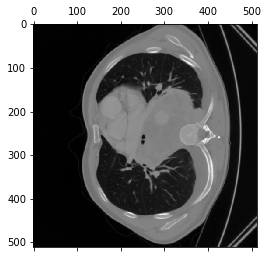

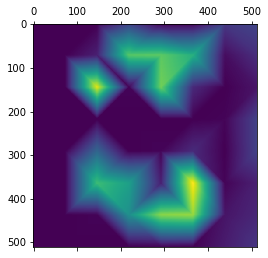

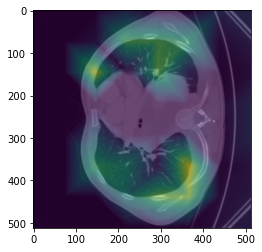

In [10]:
spacing = 10
blockSize = 63

#create layers with spacing between them ---> slices
layers = []
for i in range(int(413/spacing)):
        layers.append(image_data[:,:, i*spacing])

#load the model from disk
rf = pickle.load(open('multipleRForest_63_n500.sav', 'rb'))

#createImg(8, "63N500", layers)

showPredLabelSlice(i=31, label=11)